In [19]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report
import xml.etree.ElementTree as ET
import nltk
import matplotlib.pyplot as plt

In [12]:
def read_train_data(file_path, num=None):
    with open(file_path, 'r', encoding="utf-8") as f:
        xml_string = f.read()
    
    root = ET.fromstring(xml_string)
    texts = []
    labels = []
    
    for doc in root.findall('.//doc'):
        parti_elem = doc.find('.//PARTI')
        if parti_elem is not None:
            party = parti_elem.get('valeur')
            text_elem = doc.find('.//texte')
            if text_elem is not None:
                paragraphs = [p.text for p in text_elem.findall('p') if p.text]
                full_text = ' '.join(paragraphs)
                texts.append(full_text)
                labels.append(party)
    if num:
        return texts[:num], labels[:num]
    else:
        return texts, labels

def read_test_data(xml_file_path, ref_file_path, num=None):
    
    id_to_texts = {}
    texts = []
    labels = []
    
    with open(xml_file_path, 'r', encoding="utf-8") as f:
        xml_string = f.read()
        
    root = ET.fromstring(xml_string)
    
    for doc in root.findall('.//doc'):
        text_id = doc.get('id')
        text_elem = doc.find('.//texte')
        if text_elem is not None:
            paragraphs = [p.text for p in text_elem.findall('p') if p.text]
            full_text = ' '.join(paragraphs)
            id_to_texts[text_id] = full_text
            
    with open(ref_file_path, 'r', encoding="utf-8") as f:
        ref_string = f.read()
        
    for line in ref_string.split("\n"):
        line_elem = line.strip().split("\t")
        if line_elem[0] in id_to_texts:
            texts.append(id_to_texts[line_elem[0]])
            labels.append(line_elem[1])
            
    if num:
        return texts[:num], labels[:num]
    else:
        return texts, labels

def build_corpus(train_texts, embedding_dim):
    word_2_index = {"<PAD>": 0, "<UNK>": 1}
    for text in train_texts:
        for word in text:
            word_2_index[word] = word_2_index.get(word, len(word_2_index))
    return word_2_index, nn.Embedding(len(word_2_index), embedding_dim)

In [13]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, word_2_index, max_len):
        self.texts = texts
        self.labels = labels
        self.word_2_index = word_2_index
        self.max_len = max_len
        
    def __getitem__(self, index):
        text = self.texts[index][:self.max_len]
        label = self.labels[index]
        
        text_idx = [self.word_2_index.get(word, 1) for word in text]
        text_idx = text_idx + [0] * (self.max_len - len(text_idx))
        text_idx = torch.tensor(text_idx).unsqueeze(0)
        
        return text_idx, label
    
    def __len__(self):
        return len(self.texts)

In [14]:
class Block(nn.Module):
    def __init__(self, kernel_s, embedding_dim, max_len):
        super().__init__()
        # in_channel(输入形状): 1 * 1 * 100 * 5 (batch * in_channel * max_len * emb_dim)
        self.cnn = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(kernel_s, embedding_dim)) 
        self.act = nn.ReLU()
        self.mxp = nn.MaxPool1d(kernel_size=(max_len-kernel_s+1))
        
    def forward(self, batch_emb):
        c = self.cnn.forward(batch_emb)
        a = self.act.forward(c)
        a = a.squeeze(dim=-1)
        m = self.mxp.forward(a)
        m = m.squeeze(dim=-1)
        return m
    
# 模型部分
class TextCNN(nn.Module):
    def __init__(self, emb_matrix, max_len, class_num):
        super().__init__()
        self.emb_matrix = emb_matrix
        self.embedding_dim = self.emb_matrix.weight.shape[1]
        self.block1 = Block(2, self.embedding_dim, max_len)
        self.block2 = Block(3, self.embedding_dim, max_len)
        self.block3 = Block(4, self.embedding_dim, max_len)
        
        self.classifier = nn.Linear(6,  class_num)
        self.loss_fun = nn.CrossEntropyLoss()
    
    def forward(self, batch_idx, batch_label=None):
        batch_emb = self.emb_matrix(batch_idx)
        b1_result = self.block1.forward(batch_emb)
        b2_result = self.block2.forward(batch_emb)
        b3_result = self.block3.forward(batch_emb)
        
        feature = torch.cat([b1_result, b2_result, b3_result], dim=1) # 32 * 6 (batch_size * 6) 6为线性层的输入维度，固定的，因为是三个卷积后经过maxpooling的结果
        prediction = self.classifier(feature)
        if batch_label is not None:
            loss = self.loss_fun(prediction, batch_label)
            return loss
        else:
            return torch.argmax(prediction, dim=-1)

In [15]:
label_mapping = {
    "ELDR": 0,
    "GUE-NGL": 1,
    "PPE-DE": 2,
    "PSE": 3,
    "Verts-ALE": 4
}

train_texts, train_labels = read_train_data("./Corpus d_apprentissage/deft09_parlement_appr_en.xml")
test_texts, test_labels = read_test_data("./Corpus de test/deft09_parlement_test_en.xml", "./Données de référence/deft09_parlement_ref_en.txt", 5000)

train_texts = [[token.lower() for token in nltk.word_tokenize(text)] for text in train_texts]
train_labels = [label_mapping[name] for name in train_labels]
# train_texts必须是这样的：[["I", "am", "taotao"], ["she", "is", "laolao"]]
# train_labels必须是这样的：[1, 2, 0]

test_texts = [[token.lower() for token in nltk.word_tokenize(text)] for text in test_texts]
test_labels = [label_mapping[name] for name in test_labels]

In [21]:
embedding_dim = 20
max_len = 200
class_num = len(set(train_labels))
batch_size = 64
epoch = 50
lr = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

word_2_index, words_embedding = build_corpus(train_texts, embedding_dim)

train_dataset = TextDataset(train_texts, train_labels, word_2_index, max_len=max_len)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
# dataloader只是用来给train_dataset分batch，不改变其中的数据

test_dataset = TextDataset(test_texts, test_labels, word_2_index, max_len=max_len)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = TextCNN(words_embedding, max_len, class_num).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=lr)

losses, accuracy = [], []

for e in range(epoch):
    
    train_loss, train_total = 0, 0
    for batch_idx, batch_label in train_loader:
        batch_idx = batch_idx.to(device)
        batch_label = batch_label.to(device)
        loss = model.forward(batch_idx, batch_label)
        # 后面分batch将数据喂入模型
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss += loss.item() * batch_idx.size(0)
        train_total += batch_idx.size(0)
    
    test_correct, test_total = 0, 0
    for batch_idx, batch_label in test_loader:
        batch_idx = batch_idx.to(device)
        batch_label = batch_label.to(device)
        
        pre = model.forward(batch_idx)
        test_correct += int(torch.sum(pre == batch_label).item())
        test_total += batch_idx.size(0)
    
    epoch_loss = train_loss / train_total
    epoch_acc = test_correct / test_total
    
    losses.append(epoch_loss)
    accuracy.append(epoch_acc)
    
    print(f"Epoch [{e+1}/{epoch}]: Train Loss: {epoch_loss:.3f} | "
          f"Test Acc: {epoch_acc*100:.2f}%")

Epoch [1/50]: Train Loss: 1.495 | Test Acc: 37.06%
Epoch [2/50]: Train Loss: 1.426 | Test Acc: 39.94%
Epoch [3/50]: Train Loss: 1.362 | Test Acc: 43.26%
Epoch [4/50]: Train Loss: 1.274 | Test Acc: 45.52%
Epoch [5/50]: Train Loss: 1.170 | Test Acc: 48.50%
Epoch [6/50]: Train Loss: 1.075 | Test Acc: 50.30%
Epoch [7/50]: Train Loss: 0.985 | Test Acc: 52.00%
Epoch [8/50]: Train Loss: 0.915 | Test Acc: 53.96%
Epoch [9/50]: Train Loss: 0.846 | Test Acc: 55.30%
Epoch [10/50]: Train Loss: 0.794 | Test Acc: 56.72%
Epoch [11/50]: Train Loss: 0.762 | Test Acc: 56.28%
Epoch [12/50]: Train Loss: 0.738 | Test Acc: 55.34%
Epoch [13/50]: Train Loss: 0.714 | Test Acc: 56.68%
Epoch [14/50]: Train Loss: 0.665 | Test Acc: 58.64%
Epoch [15/50]: Train Loss: 0.602 | Test Acc: 60.42%
Epoch [16/50]: Train Loss: 0.545 | Test Acc: 61.78%
Epoch [17/50]: Train Loss: 0.497 | Test Acc: 62.72%
Epoch [18/50]: Train Loss: 0.463 | Test Acc: 63.42%
Epoch [19/50]: Train Loss: 0.442 | Test Acc: 63.48%
Epoch [20/50]: Train 

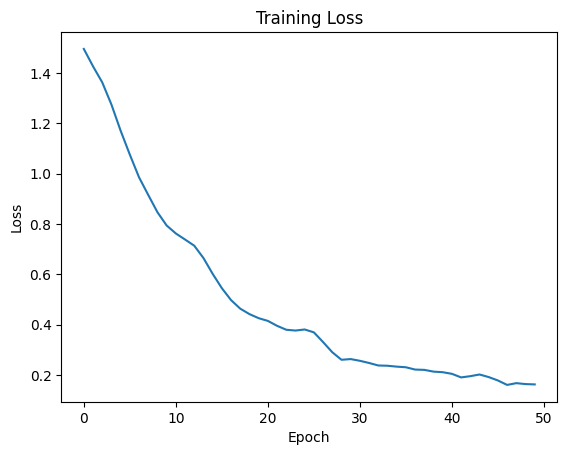

In [22]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

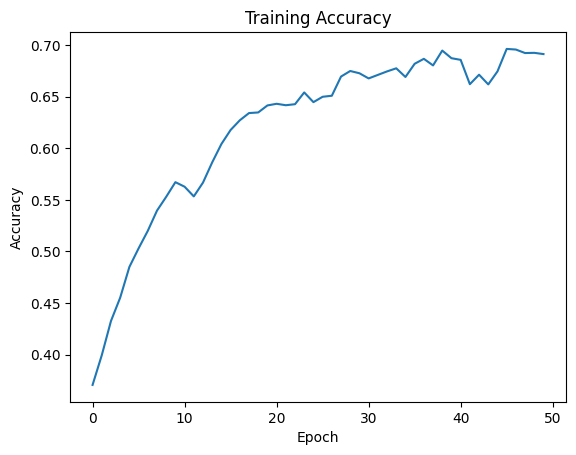

In [23]:
plt.plot(accuracy)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [56]:
predictions = []
test_labels = []

for test_idx, test_label in test_dataset:
    test_idx = test_idx.to(device).unsqueeze(1)
    prediction = model.forward(test_idx)
    predictions.append(prediction.cpu().numpy())
    test_labels.append(test_label)

predictions = np.concatenate(predictions, axis=0)
print(predictions)

[2 2 4 ... 1 4 2]


In [57]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.65      0.62      0.64       515
           1       0.72      0.70      0.71       723
           2       0.69      0.78      0.73      1752
           3       0.76      0.61      0.68      1384
           4       0.60      0.66      0.63       626

    accuracy                           0.69      5000
   macro avg       0.68      0.67      0.68      5000
weighted avg       0.70      0.69      0.69      5000

